# Spatial-temporal Correlated Random Fields (SCRF)

Author: Cindy Chiao  
Date: 12/29/2021

The purpose of this notebook is to generate spatially and temporally correlated random fields to be used to perturb the mean prediction result of GARD downscaling method. First, we use ERA5 observation data to find the appropriate length scales of correlation both spatially and temporally. Then, we use the correlation length scales to generate random fields covering the global domain in the resolution of ERA5. The package [gstools](https://geostat-framework.readthedocs.io/projects/gstools/en/stable/#pip) is used heavily in this process. A SCRF is generated for precipitation and another for temperature (will be used to perturb both tmin and tmax prediction result). 

Ideally, the entire available observation time series of the global domain would be used in determining the correlation length scales, and the SCRF of the entire future prediction period would be generated as one contiguous dataset. However, this proves to be prohibitive in terms of computation time due to the single threaded nature of the gstools algorithm. Thus, random subsamples of the observation time series were used to find the correlation length, and the SCRF was generated in 10 year long chunks. 

To find a representative spatial correlation length, we calculate the average spatial correlation lengths of 100 20x20 degree maps of 365 day time series. The 20x20 degree maps are constrained to areas of the globe that contain major landmass, avoiding the areas where it's majority ocean. 

To find a representative temporal correlation length, we use 10,000 samples of 365 day time series, again constrained to the areas containing major landmass. 

The spatial/temporal length scales for tmin and tmax are then averaged to be the length scale used to generate SCRF for temperature. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fsspec
import os
import time
import random 
import xarray as xr
import numpy as np
import pandas as pd
import gstools as gs
import rioxarray
import xesmf as xe
# from cmip6_downscaling.workflows.paths import make_scrf_path
from cmip6_downscaling.data.observations import get_obs

random.seed(20211228)

In [3]:
from carbonplan_trace.tiles import tiles
from carbonplan_trace.v1 import utils


## Finding correlation length scales

In [4]:
# get all 20x20 degree tiles that covers at least one 10x10 degree tile that has major land mass 

expanded_tiles = []
for tile in tiles:
    lat, lon = utils.get_lat_lon_tags_from_tile_path(tile)
    min_lat, max_lat, min_lon, max_lon = utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
    
    for i in [-1, 0]:
        for j in [-1, 0]: 
            lat_tag, lon_tag = utils.get_lat_lon_tags_from_bounding_box(max_lat + (i * 10.), min_lon + (j * 10.))
            expanded_tiles.append(f'{lat_tag}_{lon_tag}')
            
expanded_tiles = list(set(expanded_tiles))
expanded_tiles = [t for t in expanded_tiles if '190W' not in t and '170E' not in t and '80N' not in t and '80S' not in t]

In [5]:
def convert_long3_to_long1(long3):
    # see https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515
    long1 = (long3 + 180) % 360 - 180
    return long1

In [6]:
variables = ['tasmax', 'tasmin', 'pr']
seasonality_period = 31

sample_length = 365
n_samples_temporal = 10000
n_tiles_spatial = 100

In [7]:
def get_spatial_length(data):
    fields = data.values
    print(np.mean(fields))
    bin_center, gamma = gs.vario_estimate(
        pos=(data.lon.values, data.lat.values),
        field=fields,
        latlon=True,
        mesh_type='structured',
    )
    spatial = gs.Gaussian(dim=2, latlon=True, rescale=gs.EARTH_RADIUS)
    spatial.fit_variogram(bin_center, gamma, sill=np.mean(np.var(fields, axis=(1, 2))))

    return spatial.len_scale

In [8]:
# spatial length scale 

for v in variables:
    print(v)
    fname = f'{v}_spatial_length_scale.csv'
    if os.path.exists(fname):
        df = pd.read_csv(fname)
        df = df.loc[df.spatial_length_scale > 1]
        print(df.spatial_length_scale.mean())
    else:
        data = get_obs(
            obs='ERA5',
            train_period_start=1980,
            train_period_end=2020,
            variables=v,
            chunking_approach=None,
        )[v]

        if v == 'pr':
            data = data * 1e6

        # go from 0-360 to -180-180 longitude 
        data['lon'] = convert_long3_to_long1(data.lon)
        data = data.reindex(lon=sorted(data.lon.values))

        # detrend 
        seasonality = (
            data.rolling({'time': seasonality_period}, center=True, min_periods=1)
            .mean()
            .groupby('time.dayofyear')
            .mean()
        )
        detrended = data.groupby("time.dayofyear") - seasonality
        detrended = detrended.transpose('time', 'lon', 'lat')
        possible_time_starts = len(detrended.time) - sample_length

        spatial_length_scale = []
        chosen_tiles = random.sample(expanded_tiles, k=n_tiles_spatial)
        for tile in chosen_tiles:
            lat, lon = utils.get_lat_lon_tags_from_tile_path(tile)
            min_lat, max_lat, min_lon, max_lon = utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
            max_lat += 10
            max_lon += 10 
            t = random.randint(a=0, b=possible_time_starts)
            sub = detrended.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon)).isel(time=slice(t, t+sample_length))
            # spatial_length_scale.append(client.persist(get_spatial_length(sub), retries=1))
            l = get_spatial_length(sub)
            spatial_length_scale.append(l)
            print(tile, l)

        df = pd.DataFrame({'tile': chosen_tiles, 'spatial_length_scale': spatial_length_scale})
        df.to_csv(f'{v}_spatial_length_scale.csv')
        df = df.loc[df.spatial_length_scale > 1]
        print(df.spatial_length_scale.mean())

tasmax
437.36955028922074
tasmin
419.73912697665384
pr
404.29331338341586


In [9]:
sample_length = 100
temporal_scaler = 100.

In [10]:

# # temporal length scale 
# for v in variables:
#     print(v)
#     data = get_obs(
#         obs='ERA5',
#         train_period_start=1980,
#         train_period_end=2020,
#         variables=v,
#         chunking_approach=None,
#     )[v]

#     if v == 'pr':
#         data = data * 1e3

#     # go from 0-360 to -180-180 longitude 
#     data['lon'] = convert_long3_to_long1(data.lon)
#     data = data.reindex(lon=sorted(data.lon.values))
    
#     # detrend 
#     print('detrending')
#     seasonality = (
#         data.rolling({'time': seasonality_period}, center=True, min_periods=1)
#         .mean()
#         .groupby('time.dayofyear')
#         .mean()
#     )
#     detrended = data.groupby("time.dayofyear") - seasonality
#     detrended = detrended.transpose('time', 'lon', 'lat')
#     possible_time_starts = len(detrended.time) - sample_length
#     detrended = detrended.stack(point=['lat', 'lon'])
    
#     print('building samples')
#     points = []

#     chosen_tiles = random.choices(tiles, k=n_samples_temporal)
#     ii = random.choices(np.arange(40), k=n_samples_temporal)
#     jj = random.choices(np.arange(40), k=n_samples_temporal)

#     lat_lon_tags = [utils.get_lat_lon_tags_from_tile_path(tile) for tile in chosen_tiles]
#     bounding_boxes = [
#         utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
#         for lat, lon in lat_lon_tags
#     ]

#     for bounding_box, i, j in zip(bounding_boxes, ii, jj):
#         min_lat, max_lat, min_lon, max_lon = bounding_box
#         lat = min_lat + i * 0.25
#         lon = min_lon + j * 0.25
#         points.append((lat, lon))

#     points.sort(key=lambda u: u[0])
#     sub = detrended.sel(point=points).load()
    
#     t_starts = np.array(random.choices(np.arange(possible_time_starts), k=n_samples_temporal))
#     t_ends = t_starts + sample_length

#     fields = []
#     for i, (start, end) in enumerate(zip(t_starts, t_ends)):
#         f = sub.isel(point=i, time=slice(start, end)).values
#         fields.append(f)

#     print('finding correlation length')
#     t = np.arange(sample_length) / temporal_scaler
#     bin_center, gamma = gs.vario_estimate(pos=t, field=fields, mesh_type='structured')
#     temporal = gs.Gaussian(dim=1)
#     temporal.fit_variogram(bin_center, gamma, sill=np.mean(np.var(fields, axis=1)))
    
#     print(v, temporal.len_scale * temporal_scaler)

## Generating SRCF

In [11]:
# in units of km 
spatial_scales = {
    'tasmax': 437.36955028922074,
    'tasmin': 419.73912697665384, 
    'pr': 404.29331338341586
}

# in units of day 
temporal_scales = {
    'tasmax': 3.725572253986237,
    'tasmin': 3.9400152223556937, 
    'pr': 2.0457947933307676
}

In [12]:
import dask 
def make_scrf_path(
    obs: str,
    label: str,
    start_year: str,
    end_year: str,
    **kwargs,
):
    return f"scrf/{obs}_{label}_{start_year}_{end_year}.zarr"
    # return f"scrf/{crs.split('=')[-1]}_test.zarr"

# @dask.delayed
def generate_scrf(
    variable,
    spatial_scales,
    temporal_scales,
    start_year,
    end_year,
):
    if variable == 'temp':
        path = make_scrf_path('ERA5', 'tasmin', start_year, end_year)
        store = fsspec.get_mapper(f'az://flow-outputs/intermediate/' + path)
    else:
        path = make_scrf_path('ERA5', 'pr', start_year, end_year)
        store = fsspec.get_mapper(f'az://flow-outputs/intermediate/' + path)
    
    print(path)
    if '.zmetadata' in store:
        return ('skipping', path)

    # get the correct temporal and spatial scales to use 
    print('initializing model')
    if variable == 'temp':
        ss = np.round(np.mean([spatial_scales['tasmax'], spatial_scales['tasmin']]), 1)
        ts = np.round(np.mean([temporal_scales['tasmax'], temporal_scales['tasmin']]), 1)
        v = 'tasmax'
    elif variable == 'pr':
        ss = np.round(spatial_scales['pr'], 1)
        ts = np.round(temporal_scales['pr'], 1)
        v = 'pr'
        
    # initializing model 
    model = gs.Gaussian(dim=3, var=1.0, len_scale=[ss, ss, ts])
    srf = gs.SRF(model, seed=int(start_year)+len(variable))

    print('getting template')
    template = get_obs(
        obs='ERA5',
        train_period_start=1980,
        train_period_end=1980,
        variables=v,
        chunking_approach=None,
    )[v].isel(time=0)
    template['lon'] = convert_long3_to_long1(template.lon)
    template = template.reindex(lon=sorted(template.lon.values))
    template = template.rename({'lon': 'x', 'lat': 'y'})
    
    mill_template = xr.DataArray(
        0,
        dims=['x', 'y'],
        coords=[np.linspace(start=-20000000, stop=20000000, num=360),
                np.linspace(start=-14000000, stop=14000000, num=181)]
    )
    mill_template = mill_template.rio.write_crs('+proj=mill')

    projected = template.rio.write_crs('EPSG:4326').rio.reproject_match(mill_template)
    # transform from m to km 
    x = np.round(projected.x.values / 1000., 2) 
    y = np.round(projected.y.values / 1000., 2)
    
    # get number of days in the period 
    t = pd.date_range(
        start=f'{start_year}-01-01', 
        end=f'{end_year}-12-31', 
        freq='D')
    print(len(x), len(y), len(t))

    print('generating field')
    # generate field 
    time = np.arange(len(t))
    field = srf.structured((x, y, time))

    print('making dataarray')
    field = xr.DataArray(
        field,
        dims=['x', 'y', 'time'],
        coords=[projected.x, projected.y, t],
    ).rio.write_crs('+proj=mill')

    # reprojecting 
    print('reprojecting')
    field = field.transpose('time', 'y', 'x').rio.reproject('EPSG:4326')
    field = field.rename({'x': 'lon', 'y': 'lat'})
    template = template.rename({'x': 'lon', 'y': 'lat'})
    
    # regridding 
    print('regridding')
    regridder = xe.Regridder(field, template, "bilinear", extrap_method="nearest_s2d")
    regridded_field = regridder(field)
    
    print('saving')
    # save to file     
    if variable == 'temp':
        for v in ['tasmax', 'tasmin']:
            path = make_scrf_path('ERA5', v, start_year, end_year)
            store = fsspec.get_mapper('az://flow-outputs/intermediate/' + path)
            regridded_field.to_dataset(name='scrf').to_zarr(store, mode="w", consolidated=True)
    else:
        path = make_scrf_path('ERA5', 'pr', start_year, end_year)
        store = fsspec.get_mapper('az://flow-outputs/intermediate/' + path)
        regridded_field.to_dataset(name='scrf').to_zarr(store, mode="w", consolidated=True)                       
    
    return ("processed", path)

In [13]:
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 'ESRI:54003')
x, y = transformer.transform(0, 180)
print(x, y)

x, y = transformer.transform(0, -180)
print(x, y)

x, y = transformer.transform(90, 0)
print(x, y)

x, y = transformer.transform(-90, 0)
print(x, y)

20015109.356056377 -8.841548578112408e-10
-20015109.356056377 -8.841548578112408e-10
0.0 14675057.854846328
0.0 -14675057.854846332


In [14]:
# transformer = Transformer.from_crs(4326, 3857)
# x, y = transformer.transform(80, 0)
# print(x, y)

# x, y = transformer.transform(85, 0)
# print(x, y)

# x, y = transformer.transform(90, 0)
# print(x, y)

In [20]:
import fsspec
import os

connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")

fs = fsspec.filesystem("az", connection_string=connection_string)

# rm_list = [f for f in fs.ls('flow-outputs/intermediate/scrf',recursive=True) if 'pr' in f]

# for f in rm_list:
#     print(f)
#     fs.rm(f, recursive=True)

In [ ]:
# %%debug --breakpoint /srv/conda/envs/notebook/lib/python3.9/site-packages/gstools/covmodel/base.py:533

for variable in ['temp', 'pr']:
    for start_year in np.arange(2011, 2100, 10):
        end_year = str(start_year + 9)
        start_year = str(start_year)
        print(variable, start_year, end_year)
        
        generate_scrf(
            variable=variable,
            spatial_scales=spatial_scales,
            temporal_scales=temporal_scales,
            start_year=start_year,
            end_year=end_year,
        )

temp 2011 2020
scrf/ERA5_tasmin_2011_2020.zarr
temp 2021 2030
scrf/ERA5_tasmin_2021_2030.zarr
temp 2031 2040
scrf/ERA5_tasmin_2031_2040.zarr
temp 2041 2050
scrf/ERA5_tasmin_2041_2050.zarr
temp 2051 2060
scrf/ERA5_tasmin_2051_2060.zarr
temp 2061 2070
scrf/ERA5_tasmin_2061_2070.zarr
temp 2071 2080
scrf/ERA5_tasmin_2071_2080.zarr
temp 2081 2090
scrf/ERA5_tasmin_2081_2090.zarr
temp 2091 2100
scrf/ERA5_tasmin_2091_2100.zarr
pr 2011 2020
scrf/ERA5_pr_2011_2020.zarr
initializing model
getting template
360 181 3653
generating field


In [17]:
# import fsspec
# import os

# connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")

# fs = fsspec.filesystem("az", connection_string=connection_string)

# fs.rm('flow-outputs/intermediate/scrf/ERA5_tasmin_2011_2020.zarr', recursive=True)

# Validating correlation length

In [27]:
# ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/igh_test.zarr')
# ds = ds.transpose('time', 'lat', 'lon').scrf
# ds.isel(time=0).plot(robust=True)


# p = ds.isel(time=0).plot(
#     subplot_kws=dict(projection=ccrs.Orthographic(60, 0), facecolor="gray"),
#     transform=ccrs.PlateCarree())

# p = ds.isel(time=0).plot(
#     subplot_kws=dict(projection=ccrs.Orthographic(60, 90), facecolor="gray"),
#     transform=ccrs.PlateCarree())

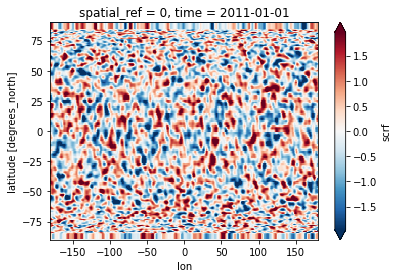

In [17]:
# get the random field output 
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_pr_2011_2020.zarr').scrf
ds.isel(time=0).plot(robust=True)

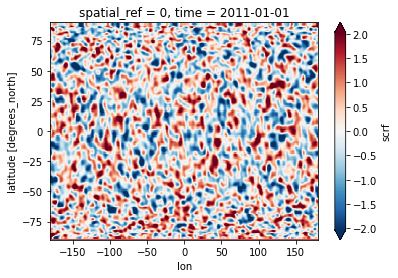

In [18]:
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_tasmax_2011_2020.zarr').scrf
ds.isel(time=0).plot(robust=True)

In [19]:
import cartopy.crs as ccrs

def globe_plot(ds, lat=60, lon=0):
    ds.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(lat, lon), facecolor="gray"),
    transform=ccrs.PlateCarree())

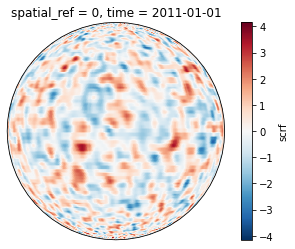

In [21]:
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_pr_2011_2020.zarr').scrf
globe_plot(ds, 60, 0)

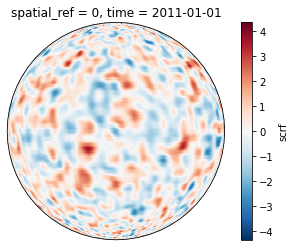

In [24]:
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_tasmax_2011_2020.zarr').scrf
globe_plot(ds, 60, 0)

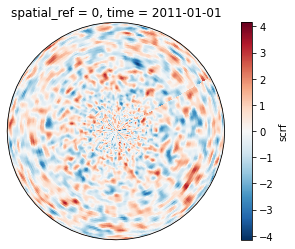

In [25]:
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_pr_2011_2020.zarr').scrf
globe_plot(ds, 60, 90)

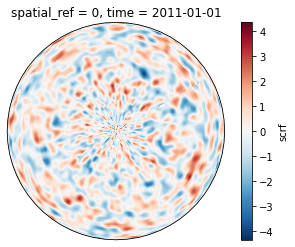

In [26]:
ds = xr.open_zarr('az://flow-outputs/intermediate/scrf/ERA5_tasmax_2011_2020.zarr').scrf
globe_plot(ds, 60, 90)

In [22]:
# spatial length -- 308km instead of 404km in input 

possible_time_starts = len(ds.time) - sample_length

spatial_length_scale = []
chosen_tiles = random.sample(expanded_tiles, k=n_tiles_spatial)
for tile in chosen_tiles:
    lat, lon = utils.get_lat_lon_tags_from_tile_path(tile)
    min_lat, max_lat, min_lon, max_lon = utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
    max_lat += 10
    max_lon += 10 
    t = random.randint(a=0, b=possible_time_starts)
    sub = ds.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon)).isel(time=slice(t, t+sample_length))
    l = get_spatial_length(sub)
    spatial_length_scale.append(l)
    print(tile, l)

df = pd.DataFrame({'tile': chosen_tiles, 'spatial_length_scale': spatial_length_scale})
df = df.loc[df.spatial_length_scale > 1]
print(df.spatial_length_scale.mean())

0.013826714904010717
60N_180W 282.59043354184644
-0.052318098502946865
30N_110W 213.91333096451717
-0.011196575048319616
60N_090E 136.9918728773209
0.006220651287832765
20N_160W 358.1296549841321
0.009496102078452393
60N_020W 283.7959578051277
0.008637462895534923
50N_120W 183.58314847045148
0.014732792871865415
40S_120E 282.9855127611441
-0.04393255743794771
40S_160E 301.7715659054041
0.06982743655871809
40N_030W 374.579602568172
0.02005309626097596
00N_040W 376.41416543760266
2.984686132076732e-05
50S_160E 287.2918336086338
-0.04225238227082814
20S_110E 256.0912057791521
0.019957721142871462
30S_070W 241.07776584250715
0.05844702182773759
50N_060E 170.70754269550966
-0.05692017984624532
10S_130E 326.08125398588385
0.031414723522313184
10S_050E 275.1678005028345
0.07435395393733825
00N_060E 207.06291590294677
-0.04616480714357835
30N_160W 345.7336636113519
-0.01203052025786012
20S_020E 385.7940474836749
-0.003943333361014467
10N_110E 254.3078094991031
0.010788219127247834
60N_110E 203

In [23]:
# temporal length scale --> 1.78 days instead of 2.05 days in input 
print('building samples')
points = []

chosen_tiles = random.choices(tiles, k=n_samples_temporal)
ii = random.choices(np.arange(40), k=n_samples_temporal)
jj = random.choices(np.arange(40), k=n_samples_temporal)

lat_lon_tags = [utils.get_lat_lon_tags_from_tile_path(tile) for tile in chosen_tiles]
bounding_boxes = [
    utils.parse_bounding_box_from_lat_lon_tags(lat, lon)
    for lat, lon in lat_lon_tags
]

for bounding_box, i, j in zip(bounding_boxes, ii, jj):
    min_lat, max_lat, min_lon, max_lon = bounding_box
    lat = min_lat + i * 0.25
    lon = min_lon + j * 0.25
    points.append((lat, lon))

points.sort(key=lambda u: u[0])
sub = ds.stack(point=['lat', 'lon']).sel(point=points).load()

t_starts = np.array(random.choices(np.arange(possible_time_starts), k=n_samples_temporal))
t_ends = t_starts + sample_length

fields = []
for i, (start, end) in enumerate(zip(t_starts, t_ends)):
    f = sub.isel(point=i, time=slice(start, end)).values
    fields.append(f)

print('finding correlation length')
t = np.arange(sample_length) / temporal_scaler
bin_center, gamma = gs.vario_estimate(pos=t, field=fields, mesh_type='structured')
temporal = gs.Gaussian(dim=1)
temporal.fit_variogram(bin_center, gamma, sill=np.mean(np.var(fields, axis=1)))

print(temporal.len_scale * temporal_scaler)

building samples
finding correlation length
1.778582376367958
